In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV

In [41]:
# Importing clean, ready to go dataset from previous exercise 2
df = pd.read_csv("../exercise2/log_reg_df_clean.csv")
metrics_df = pd.read_csv("../exercise2/metrics.csv")
# Drop random spawning column after loading metrics
metrics_df.drop("Unnamed: 0", axis=1, inplace=True)

Split the dataset:

In [42]:
# X = everything else in the DataFrame minus the target variable
# y = only the target variable
X = df.drop('booking_status', axis=1)
y = df['booking_status']

# split the data into train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [50]:
# Initiate regression and fit in the data
model = make_pipeline(StandardScaler(), svm.SVC(probability=True))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

Check metrics:

In [51]:
 # get predictions for error metrics
predictions = model.predict(X_test)
 # print the classification report based on true values and predictions
report = classification_report(y_test, predictions, output_dict=True)
# get overall accuracy of the model
acc = round(accuracy_score(y_test, predictions), 2)
# get roc acu score of the model
roc_auc = round(roc_auc_score(y_test.values, model.predict_proba(X_test)[:, 1]), 2)

metrics_df["Basic SVC"] = [acc,
                           round(report['macro avg']['precision'], 2),
                           round(report['macro avg']['recall'], 2),
                           round(report['macro avg']['f1-score'], 2),
                           round(report['weighted avg']['precision'], 2),
                           round(report['weighted avg']['recall'], 2),
                           round(report['weighted avg']['f1-score'], 2),
                           roc_auc]
metrics_df



,Metric,Basic Model,StandardScaler + LogisticRegression,StandardScaler + Regularization + LogisticRegression,Basic SVC,"SVC, linear kernel"
0,Total accuracy,0.78,0.78,0.81,0.82,0.79
1,Macro precision,0.77,0.77,0.80,0.81,0.77
2,Macro recall,0.75,0.75,0.78,0.78,0.75
3,Macro F1,0.75,0.75,0.78,0.79,0.76
4,Weighted precision,0.78,0.78,0.81,0.82,0.78
5,Weighted recall,0.78,0.78,0.81,0.82,0.79
6,Weighted F1,0.78,0.78,0.81,0.81,0.78
7,ROC AUC,0.76,0.76,0.61,0.87,0.84


<Axes: >

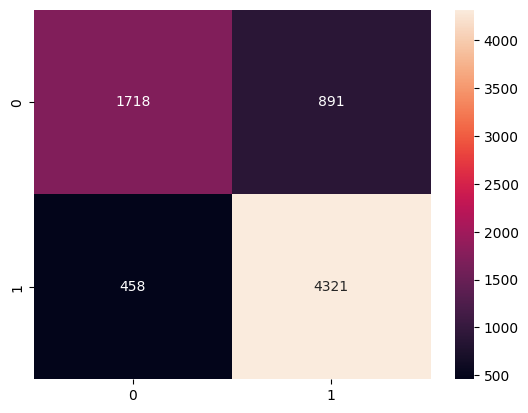

In [53]:
# confusion matrix, fmt parameter helps to get rid of scientific annotaion.
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

Even though it shows generally better metrics, model still have problems with predicting 0 values.
Explanation is quite simple - original dataset is imbalanced, target value has 2 times more positive outcomes then negative ones. That's why model is biased towards positive values and is quite good with recognizing positive values, but struggling with negative values and falsely cllassifies them as positives in too much cases. 

Now let's try to hightune parameters and try out different kernels of this model, such as common SVC, Linear SVC and NuSVC. Using GridSearchCV

In [54]:
# Initialize parameters, our common SVC model with linear kernel supports such parameters as:

# C - values between 0-1000. Regularization parameter

# Let's try different random parameters and see in which way we should move. After that increase or decrease values closer to best parameters and see if there is any space for improvement

param_grid = {
    'C': [0.1, 0.25, 0.5],
    "kernel": ["linear"],
}

In [55]:
# make a pipeline, and wrap SVM model into the GridSearchCV
# probability=True parameter slows down fitting but allows to use predict_proba which is used in roc_auc_score metrics. 
# However, fitting was too slow and I decided to go another way around using decision scores.
# n_jobs parameter allows to tun paralell threads tto improve speed of GridSearchCV. -2 means that python will use all CPUs will be used but 1
model = make_pipeline(StandardScaler(), GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3, n_jobs=-2))
model.fit(X_train, y_train) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.784 total time=  10.7s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.791 total time=  10.8s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.783 total time=  10.8s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.798 total time=  10.9s
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.784 total time=  11.0s
[CV 2/5] END .............C=0.25, kernel=linear;, score=0.798 total time=  11.2s
[CV 1/5] END .............C=0.25, kernel=linear;, score=0.784 total time=  11.3s
[CV 4/5] END .............C=0.25, kernel=linear;, score=0.781 total time=  10.9s
[CV 3/5] END .............C=0.25, kernel=linear;, score=0.784 total time=  11.1s
[CV 5/5] END .............C=0.25, kernel=linear;, score=0.791 total time=  11.2s
[CV 1/5] END ..............C=0.5, kernel=linear;, score=0.784 total time=  11.3s
[CV 4/5] END ..............C=0.5, kernel=linear;,

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=SVC(), n_jobs=-2,
                              param_grid={'C': [0.1, 0.25, 0.5],
                                          'kernel': ['linear']},
                              verbose=3))])

In [56]:
 # get predictions for error metrics
predictions = model.predict(X_test)
 # print the classification report based on true values and predictions
report = classification_report(y_test, predictions, output_dict=True)
# get overall accuracy of the model
acc = round(accuracy_score(y_test, predictions), 2)
# If probability=True is not set, can use the decision_function method.
decision_scores = model.decision_function(X_test)
# get roc acu score of the model and print it
roc_auc = round(roc_auc_score(y_test, decision_scores), 2)

metrics_df["SVC, linear kernel"] = [acc,
                           round(report['macro avg']['precision'], 2),
                           round(report['macro avg']['recall'], 2),
                           round(report['macro avg']['f1-score'], 2),
                           round(report['weighted avg']['precision'], 2),
                           round(report['weighted avg']['recall'], 2),
                           round(report['weighted avg']['f1-score'], 2),
                           roc_auc]
metrics_df




,Metric,Basic Model,StandardScaler + LogisticRegression,StandardScaler + Regularization + LogisticRegression,Basic SVC,"SVC, linear kernel"
0,Total accuracy,0.78,0.78,0.81,0.82,0.79
1,Macro precision,0.77,0.77,0.80,0.81,0.77
2,Macro recall,0.75,0.75,0.78,0.78,0.75
3,Macro F1,0.75,0.75,0.78,0.79,0.76
4,Weighted precision,0.78,0.78,0.81,0.82,0.78
5,Weighted recall,0.78,0.78,0.81,0.82,0.79
6,Weighted F1,0.78,0.78,0.81,0.81,0.78
7,ROC AUC,0.76,0.76,0.61,0.87,0.84


<Axes: >

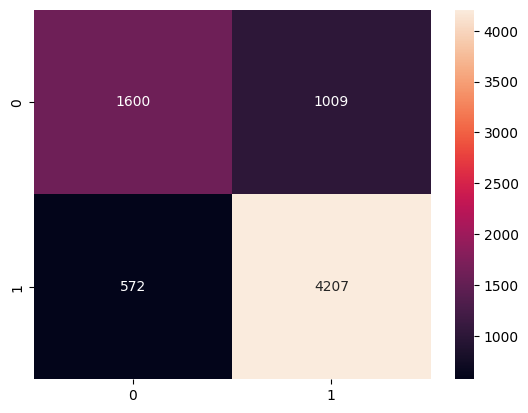

In [57]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

Linear ketnel performs slightly worse than default rbf. Still can recognize postive outcomes but situation is almost catastrophical with negatives. There it comes closer and closer to coin flip.

This time let's play around gamma hyperparameter as well.

Gamma is responsible for curvature of weight of decision boundary. 

It is a crucial hyperparameter, especially for non-linear kernels, like default rbf.

https://www.geeksforgeeks.org/gamma-parameter-in-svm/

However, high gamma could lead to overfitting, while low value can be the reason for underfitting:

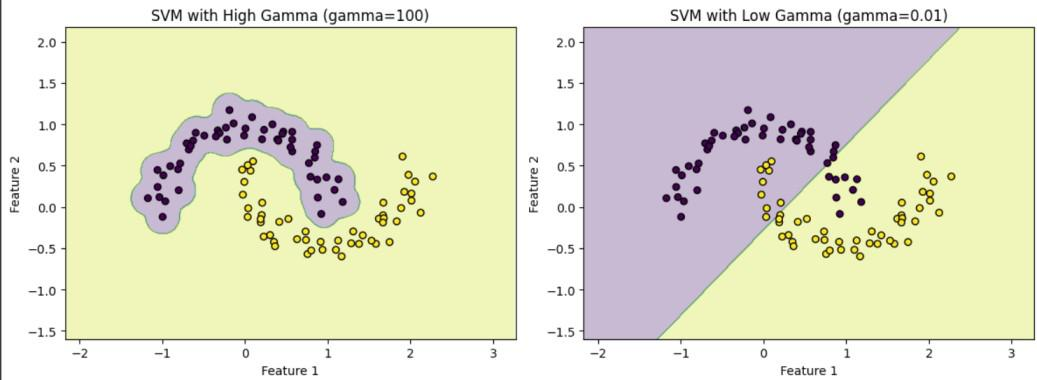

C hyperparameter in turn is responsible for controlling errors. 

Lower C value punishes model for errors stronger, which leads to less amount of error, but also to overfitting and worse decision boundary.

https://medium.com/@myselfaman12345/c-and-gamma-in-svm-e6cee48626be#:~:text=Gamma%20is%20a%20hyperparameter%20which,low%20gamma%20then%20less%20curvature.
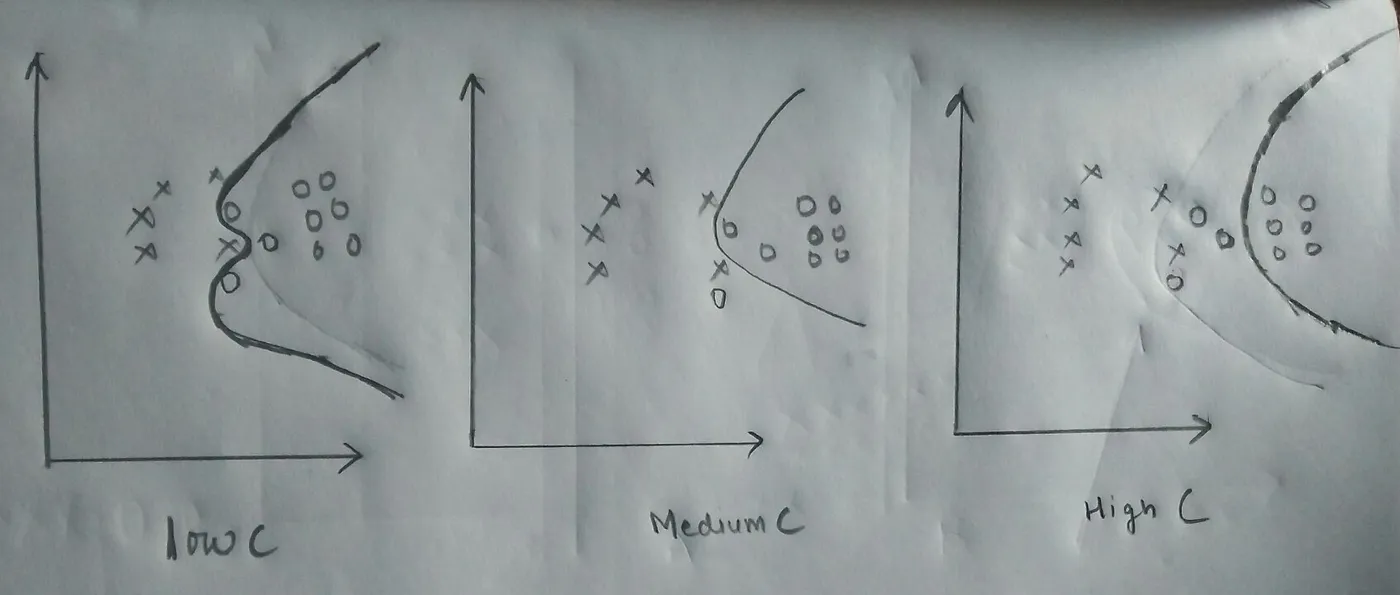


In [58]:
# Initialize parameters
# Add wider parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.3, 0.5, 1]
}

In [59]:
# make a pipeline, and wrap SVM model into the GridSearchCV
model = make_pipeline(StandardScaler(), GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3, n_jobs=-2))
model.fit(X_train, y_train) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 4/5] END ..............C=0.001, gamma=0.001;, score=0.655 total time=  17.4s
[CV 5/5] END ..............C=0.001, gamma=0.001;, score=0.655 total time=  17.7s
[CV 1/5] END ..............C=0.001, gamma=0.001;, score=0.655 total time=  17.8s
[CV 2/5] END ..............C=0.001, gamma=0.001;, score=0.655 total time=  17.8s
[CV 3/5] END ..............C=0.001, gamma=0.001;, score=0.655 total time=  18.0s
[CV 2/5] END ...............C=0.001, gamma=0.01;, score=0.655 total time=  18.0s
[CV 1/5] END ...............C=0.001, gamma=0.01;, score=0.655 total time=  18.1s
[CV 4/5] END ...............C=0.001, gamma=0.01;, score=0.655 total time=  20.6s
[CV 3/5] END ...............C=0.001, gamma=0.01;, score=0.655 total time=  21.2s
[CV 4/5] END ................C=0.001, gamma=0.1;, score=0.655 total time=  20.5s
[CV 1/5] END ................C=0.001, gamma=0.1;, score=0.655 total time=  20.8s
[CV 3/5] END ................C=0.001, gamma=0.1

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gridsearchcv',
                 GridSearchCV(estimator=SVC(), n_jobs=-2,
                              param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                          'gamma': [0.001, 0.01, 0.1, 1, 10,
                                                    100]},
                              verbose=3))])

In [61]:
 # get predictions for error metrics
predictions = model.predict(X_test)
 # print the classification report based on true values and predictions
report = classification_report(y_test, predictions, output_dict=True)
# get overall accuracy of the model
acc = round(accuracy_score(y_test, predictions), 2)
# If probability=True is not set, can use the decision_function method.
decision_scores = model.decision_function(X_test)
# get roc acu score of the model and print it
roc_auc = round(roc_auc_score(y_test, decision_scores), 2)

metrics_df["SVC, rbf hightuned"] = [acc,
                           round(report['macro avg']['precision'], 2),
                           round(report['macro avg']['recall'], 2),
                           round(report['macro avg']['f1-score'], 2),
                           round(report['weighted avg']['precision'], 2),
                           round(report['weighted avg']['recall'], 2),
                           round(report['weighted avg']['f1-score'], 2),
                           roc_auc]
metrics_df




,Metric,Basic Model,StandardScaler + LogisticRegression,StandardScaler + Regularization + LogisticRegression,Basic SVC,"SVC, linear kernel","SVC, rbf hightuned"
0,Total accuracy,0.78,0.78,0.81,0.82,0.79,0.84
1,Macro precision,0.77,0.77,0.80,0.81,0.77,0.83
2,Macro recall,0.75,0.75,0.78,0.78,0.75,0.81
3,Macro F1,0.75,0.75,0.78,0.79,0.76,0.82
4,Weighted precision,0.78,0.78,0.81,0.82,0.78,0.84
5,Weighted recall,0.78,0.78,0.81,0.82,0.79,0.84
6,Weighted F1,0.78,0.78,0.81,0.81,0.78,0.84
7,ROC AUC,0.76,0.76,0.61,0.87,0.84,0.89


<Axes: >

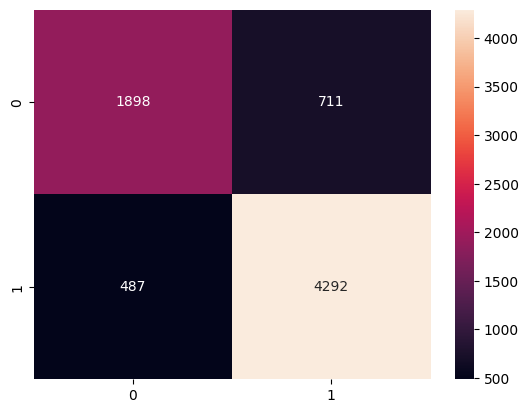

In [62]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

Compared to fisrt model (not tuned SVC with rbf kernel), tuning C and gamma helped to reduce false negatives predictions.

However, false positive amount slightly growed as well.

If I understand correctly in this particular case higher C value (less error weight) in a combo with lower gamma (more freedom for decision boundary) allowed model to make slightly more mistakes with overhelming postives outcomes and by that to improve quality of predicting negative outcomes. 

In [76]:
# Initialize parameters
# Added C=200 to check if optimal C is rather in range 100-500 then 10-100
# Reduced amount of C and gamma options to reduce needed time for gridsearching.
# Every try with degree 5 takes more then 5 minutes.
param_grid = {
    'C': [100],
    'gamma': [0.1],
    'kernel': ['poly'],
    'degree': [3,5,7]
}

In [77]:
# make a pipeline, and wrap SVM model into the GridSearchCV
model = make_pipeline(StandardScaler(), GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3, n_jobs=-2))
model.fit(X_train, y_train) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END C=100, degree=3, gamma=0.1, kernel=poly;, score=0.814 total time= 2.2min
[CV 4/5] END C=100, degree=3, gamma=0.1, kernel=poly;, score=0.811 total time= 2.3min
[CV 5/5] END C=100, degree=3, gamma=0.1, kernel=poly;, score=0.814 total time= 2.4min
[CV 3/5] END C=100, degree=3, gamma=0.1, kernel=poly;, score=0.816 total time= 2.4min
[CV 1/5] END C=100, degree=3, gamma=0.1, kernel=poly;, score=0.813 total time= 2.7min


KeyboardInterrupt: 

In [74]:
 # get predictions for error metrics
predictions = model.predict(X_test)
 # print the classification report based on true values and predictions
report = classification_report(y_test, predictions, output_dict=True)
# get overall accuracy of the model
acc = round(accuracy_score(y_test, predictions), 2)
# If probability=True is not set, can use the decision_function method.
decision_scores = model.decision_function(X_test)
# get roc acu score of the model and print it
roc_auc = round(roc_auc_score(y_test, decision_scores), 2)

metrics_df["SVC, poly kernel"] = [acc,
                           round(report['macro avg']['precision'], 2),
                           round(report['macro avg']['recall'], 2),
                           round(report['macro avg']['f1-score'], 2),
                           round(report['weighted avg']['precision'], 2),
                           round(report['weighted avg']['recall'], 2),
                           round(report['weighted avg']['f1-score'], 2),
                           roc_auc]
metrics_df




,Metric,Basic Model,StandardScaler + LogisticRegression,StandardScaler + Regularization + LogisticRegression,Basic SVC,"SVC, linear kernel","SVC, rbf hightuned","SVC, poly kernel"
0,Total accuracy,0.78,0.78,0.81,0.82,0.79,0.81,0.81
1,Macro precision,0.77,0.77,0.80,0.81,0.77,0.81,0.81
2,Macro recall,0.75,0.75,0.78,0.78,0.75,0.76,0.76
3,Macro F1,0.75,0.75,0.78,0.79,0.76,0.77,0.77
4,Weighted precision,0.78,0.78,0.81,0.82,0.78,0.81,0.81
5,Weighted recall,0.78,0.78,0.81,0.82,0.79,0.81,0.81
6,Weighted F1,0.78,0.78,0.81,0.81,0.78,0.80,0.80
7,ROC AUC,0.76,0.76,0.61,0.87,0.84,0.87,0.87


<Axes: >

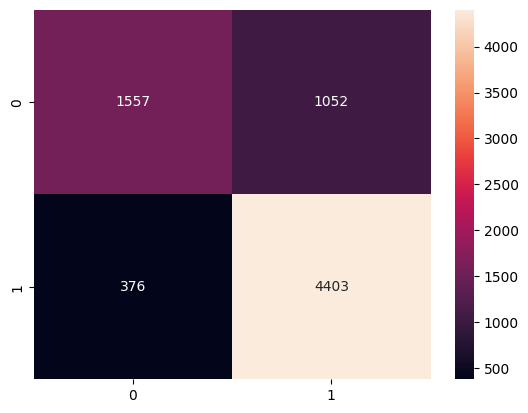

In [75]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

Sigmoid*

In [ ]:
param_grid = {
    'C': [10, 100, 500],
    'gamma': [0.1, 1],
    'kernel': ['sigmoid'],
    'epsiolon': [0.1, 0.4, 1]
}

In [ ]:
# make a pipeline, and wrap SVM model into the GridSearchCV
model = make_pipeline(StandardScaler(), GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=3, n_jobs=-2))
model.fit(X_train, y_train) 

In [ ]:
 # get predictions for error metrics
predictions = model.predict(X_test)
 # print the classification report based on true values and predictions
report = classification_report(y_test, predictions, output_dict=True)
# get overall accuracy of the model
acc = round(accuracy_score(y_test, predictions), 2)
# If probability=True is not set, can use the decision_function method.
decision_scores = model.decision_function(X_test)
# get roc acu score of the model and print it
roc_auc = round(roc_auc_score(y_test, decision_scores), 2)

metrics_df["SVC, sigmoid kernel"] = [acc,
                           round(report['macro avg']['precision'], 2),
                           round(report['macro avg']['recall'], 2),
                           round(report['macro avg']['f1-score'], 2),
                           round(report['weighted avg']['precision'], 2),
                           round(report['weighted avg']['recall'], 2),
                           round(report['weighted avg']['f1-score'], 2),
                           roc_auc]
metrics_df




In [ ]:
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')